Eigenvalue MC code

In [1]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import os

from models import globalvariables as GV
from models import geometry_models as geo_m
from models import physic_model as phy_m
from models import material_model as mat_m
from models import statistic_model as stat_m

from controllers import geometry_controller as geo_c
from controllers import physics_controller as phy_c
from controllers import material_controller as mat_c
from controllers import statistic_controller as stat_c

Import data

In [2]:
# Base directory
base_dir = 'cross_sections_Janis'

U238_total = np.loadtxt(os.path.join(base_dir, 'U238', 'U238_total.csv'), delimiter=';', skiprows=3)
U238_scattering = np.loadtxt(os.path.join(base_dir, 'U238', 'U238_scattering.csv'), delimiter=';', skiprows=3)
U238_fission = np.loadtxt(os.path.join(base_dir, 'U238', 'U238_fission.csv'), delimiter=';', skiprows=3)
U238_nu = np.loadtxt(os.path.join(base_dir, 'U238', 'U238_nu.csv'), delimiter=';', skiprows=3)

U235_total = np.loadtxt(os.path.join(base_dir, 'U235', 'U235_total.csv'), delimiter=';', skiprows=3)
U235_scattering = np.loadtxt(os.path.join(base_dir, 'U235', 'U235_scattering.csv'), delimiter=';', skiprows=3)
U235_fission = np.loadtxt(os.path.join(base_dir, 'U235', 'U235_fission.csv'), delimiter=';', skiprows=3)
U235_nu = np.loadtxt(os.path.join(base_dir, 'U235', 'U235_nu.csv'), delimiter=';', skiprows=3)

U234_total = np.loadtxt(os.path.join(base_dir, 'U234', 'U234_total.csv'), delimiter=';', skiprows=3)
U234_scattering = np.loadtxt(os.path.join(base_dir, 'U234', 'U234_scattering.csv'), delimiter=';', skiprows=3)
U234_fission = np.loadtxt(os.path.join(base_dir, 'U234', 'U234_fission.csv'), delimiter=';', skiprows=3)
U234_nu = np.loadtxt(os.path.join(base_dir, 'U234', 'U234_nu.csv'), delimiter=';', skiprows=3)

Create isotopes

In [3]:
uranium238 = mat_m.isotope(92,238,4.4984E21,U238_total[:,0],U238_total[:,1],U238_scattering[:,1],U238_fission[:,1],U238_nu[:,1])
uranium235 = mat_m.isotope(92,235,4.4994E22,U235_total[:,0],U235_total[:,1],U235_scattering[:,1],U235_fission[:,1],U235_nu[:,1])
uranium234 = mat_m.isotope(92,234,4.9184E20,U234_total[:,0],U234_total[:,1],U234_scattering[:,1],U234_fission[:,1],U234_nu[:,1])
source = phy_m.source(GV.Nstories,GV.LL,100,'watt')
particle_squeue = []

Create materials

In [4]:
core_list = [uranium238, uranium235, uranium234]
core = mat_m.material(core_list)

Tally creations

In [5]:
distribution = [(core,0,GV.LEnd)]
domain = geo_m.domain(distribution,GV.LL,1000,GV.EE,1000,True)
tally = stat_m.tally(GV.LL,2)
KK = [GV.Kin,GV.Kin]
HH = []
Keff = KK[-1]

Monte Carlo code

In [6]:
for ii in range(int(GV.Nskip)):
    phy_c.initialize_population(source,particle_squeue,domain)
    Keff = KK[-1]
    Knew = 0
    source.reset_source()
    print(ii)
    while len(particle_squeue)>0:
        nn = particle_squeue.pop(0)
        while nn.eof > 0:
            nn.position = phy_c.sample_free_flight(nn,domain)
            if geo_c.is_outofbound(nn,'space'):
                nn.eof = 0
            else:
                Knew += phy_c.implicit_fission(nn,domain,source, Keff)
                # aggiorno i dati della particella dopo l'interazione
                nn.energy = phy_c.sample_energy_stepf(nn,domain)
                nn.direction = geo_m.direction.get_rnd_direction()
                nn.weight = phy_c.implicit_capture(nn,domain)
                # controllo l'energia
                if geo_c.is_outofbound(nn,'energy') is True:
                    nn.eof = 0
                else:
                    # russian roulette e splitting
                    stat_c.russian_roulette(nn)
                    stat_c.splitting(nn,particle_squeue)
    HH.append(source.s_entropy)
    stat_c.restart_cycle()
    KK.append(Knew)

KeyboardInterrupt: 

In [7]:
len(particle_squeue)

0

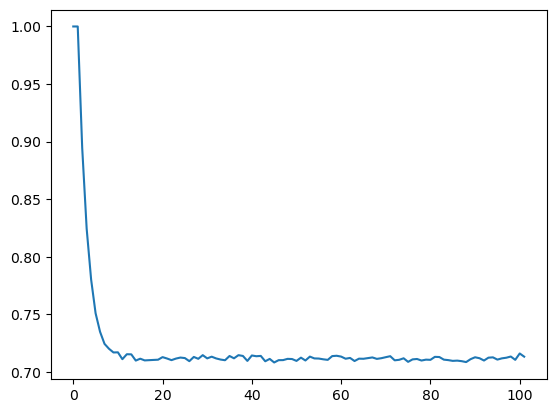

In [8]:
plt.plot(KK)

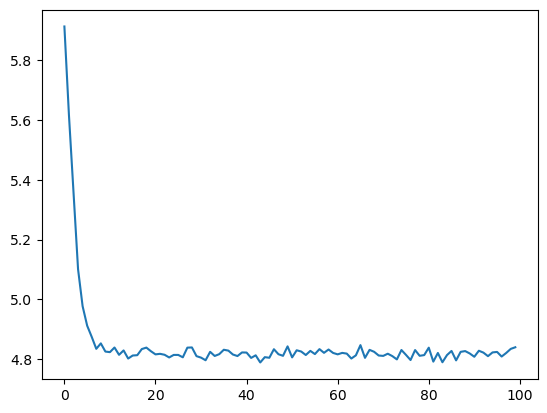

In [9]:
plt.plot(HH)

In [10]:
for ii in range(int(GV.Nactive)):
    tally.iter += 1
    phy_c.initialize_population(source,particle_squeue,domain)
    print(ii)
    Keff = KK[-1]
    Knew = 0
    source.reset_source()
    while len(particle_squeue)>0:
        nn = particle_squeue.pop(0)
        while nn.eof > 0:
            nn.position = phy_c.sample_free_flight(nn,domain)
            if geo_c.is_outofbound(nn,'space'):
                nn.eof = 0
            else:
                stat_c.count_interaction(tally,nn,domain)
                Knew += phy_c.implicit_fission(nn,domain,source, Keff)
                # aggiorno i dati della particella dopo l'interazione
                nn.energy = phy_c.sample_energy_stepf(nn,domain)
                nn.direction = geo_m.direction.get_rnd_direction()
                nn.weight = phy_c.implicit_capture(nn,domain)
                # controllo l'energia
                if geo_c.is_outofbound(nn,'energy') is True:
                    nn.eof = 0
                else:
                    # russian roulette e splitting
                    stat_c.russian_roulette(nn)
                    stat_c.splitting(nn,particle_squeue)
    stat_c.wellford(tally)
    HH.append(source.s_entropy)
    stat_c.restart_cycle()
    KK.append(Knew)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [11]:
sigma = tally.RSD
stat_c.normalization(tally)
avg = tally.avg
#avg = avg.ravel()
#sigma = sigma.ravel()

c:\Users\simon\Documents\GitHub\Transport-code-v.3\models\statistic_model.py:46: RuntimeWarning: invalid value encountered in divide
  return aa/self.mean


In [12]:
# dE = np.diff(GV.Groups)
# yy = np.zeros(len(tally.spaceref))
# yrr = np.zeros(len(tally.spaceref))
# for ii in range(len(avg)):
#     yy += avg[ii]*dE[ii]
#     yrr += sigma[ii]


In [13]:
#xx = np.sin(tally.spaceref/GV.LEnd)/tally.spaceref

In [14]:
# plt.errorbar(tally.spaceref,yy/GV.Nstories,yerr=2*sigma[-1]*yy/GV.Nstories,capsize=6)
# #plt.plot(tally.spaceref,xx)
# #plt.yscale('log')
# plt.show()

In [15]:
from math import pi

In [16]:
avg.shape

(99, 1)

In [17]:
zz = np.zeros(len(GV.Groups)-1)
zerr = np.zeros(len(GV.Groups)-1)
for jj in range(len(zz)):
    for ii in range(len(tally.spaceref)):
        zz[jj] += avg[jj][ii]*1/(4/3*pi*(tally.spacerange[ii+1]**3-tally.spacerange[ii]**3))
        zerr[jj] += sigma[jj][ii]

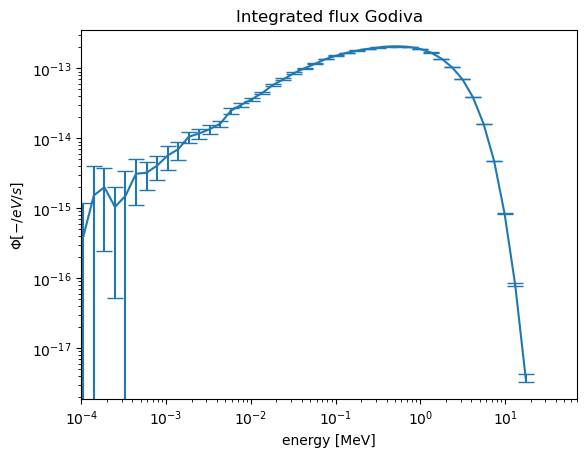

In [18]:
plt.errorbar(tally.energyref/1E6,zz/GV.Nstories,yerr=2*zerr*zz/GV.Nstories,capsize=6)
plt.xlabel('energy [MeV]')
plt.ylabel(r'$\Phi [-/eV/s]$')
plt.title('Integrated flux Godiva')
plt.yscale('log')
plt.xscale('log')
plt.xlim(left=1E-4)
plt.show()